In [2]:
!pip install tensorflow

In [3]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras import layers

2024-07-31 03:07:09.169344: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:07:09.206451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:07:09.207105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 03:07:09.903589: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
!pip install scikit-learn

In [5]:
def get_csrf_token(session):
    """Fetches the CSRF token from the login page."""
    login_url = "https://www.heartharena.com/login"
    response = session.get(login_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    csrf_token = soup.find("input", {"name": "_csrf_token"})["value"]
    return csrf_token
    
def login(username, password):
    """Logs in to the HearthArena website."""
    url = "https://www.heartharena.com/login_check"
    session = requests.Session()

    # Get CSRF token
    csrf_token = get_csrf_token(session)

    # Prepare payload
    payload = {
        "_username": username,
        "_password": password,
        "_csrf_token": csrf_token,
        "_remember_me": "on"  # Optional, based on whether you want to stay logged in
    }

    # Submit the login form
    response = session.post(url, data=payload)

    # Check if login was successful
    if response.status_code == 200:
        print("Login successful!")
    else:
        print("Login failed.")

    return session



In [6]:
def getRuns(arenaURL,session):
    # Initialize an empty list to store the links
    response = session.get(arenaURL)
    links = []
    end = BeautifulSoup(response.text, 'html')
    runs = end.find('tbody')
    # Find all 'a' tags within 'tr' elements and filter for those with 'href' attribute starting with '/arena-run/'
    for link in runs.find_all('tr'):
        anchor_tags = link.find_all('a')
        for tag in anchor_tags:
            href = tag.get('href')
            if href and href.startswith('/arena-run/'):
                links.append('https://www.heartharena.com'+href)
    links = list(set(links))
    return links

In [7]:
def getStatsFromRun(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html')
    nameExtract = soup.select('h1.class')[0].text.strip()
    parts = nameExtract.split('/')
       
    winRate = 0
    deckList = 0
    champ = ""
    hasData = len(soup.find_all('span', class_='wins'))
    print(hasData)
    if hasData == 1:
        champ = parts[0].strip() 
        wins = int(soup.find_all('span', class_='wins')[0].text)
        losses = int(soup.find_all('span', class_='losses')[0].text)
        winRate = wins/(wins+losses)
        arenaDeck = soup.find_all('ul', class_="deckList")[0]
        cardNames = arenaDeck.find_all('span', class_='name')
        cardAmount = arenaDeck.find_all('span', class_='quantity')
        # Extract and convert numeric values and names
        namesList = [(name.text.strip()) for name in cardNames]
        amountList = [int(amount.text.strip()) for amount in cardAmount]

        # Initialize an empty list to hold the repeated names
        deckList = []

        # Iterate through the names and amounts simultaneously
        for name, amount in zip(namesList, amountList):
            # Repeat the name 'amount' times and extend the repeated_names list
            deckList.extend([name] * amount)

    return champ, winRate, deckList, hasData

In [8]:
import csv

In [9]:

filename = 'cardsfromapi.csv'  # Replace with your CSV file path

# Initialize an empty list to hold the CSV data
data = []

# Open the CSV file and read its content
with open(filename, mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)


# Convert the single row DataFrame to a list
cleaned_list = data[0]

# Initialize an empty dictionary
encodedDeck = {}

# Assign a unique integer to each name
i = 1
for name in cleaned_list:
    if name not in encodedDeck:
        encodedDeck[name] = i
        i += 1
        
def encodeDeck(deck):
    for name in deck:
        if name not in encodedDeck:
            encodedDeck[name] = len(encodedDeck)

    
    empty_list = [0] * (len(encodedDeck)+1)
    for card in deck:
        empty_list[encodedDeck.get(card)]+=.5
    return empty_list

In [10]:
classes = ['Death Knight','Demon Hunter','Druid','Hunter','Mage','Paladin','Preist','Rogue','Shaman','Warlock','Warrior']

# Initialize an empty dictionary to hold the encoding
encoded_classes = {}

# Iterate over each class name
for name in classes:
    # Check if the name is already in the dictionary
    if name not in encoded_classes:
        # If not, add it with a unique integer
        encoded_classes[name] = len(encoded_classes) + 1



def encodeClass(classData):
    empty_list1 = [0] * len(encoded_classes)
    empty_list2 = [0] * len(encoded_classes)
    separated_names = classData.split(' + ')
    empty_list1[encoded_classes.get(separated_names[0])-1]+=1
    empty_list2[encoded_classes.get(separated_names[1])-1]+=1
    return empty_list1+empty_list2
    

In [11]:
def scrapeArenaData(linksList):
    # Initialize an empty list to store the outputs
    outputs = []

        # Iterate through linksList
    for link in linksList:
        # Call getStatsFromRun for each link and append the result to outputs
        
        output = getStatsFromRun(link)    
        outputs.append(output)

    return outputs

In [12]:
def getTrainingData(arenaData):
    winRateList = []
    classDeckList = []
    for run in arenaData:
        print(run[3])
        if run[3] == 1:
            classEncoded = encodeClass(run[0])
            winRate = run[1]
            deckEncoded = encodeDeck(run[2])
            classDeckList.append(classEncoded + deckEncoded)
            winRateList.append(winRate)
    return classDeckList, winRateList
    

In [13]:
session = login("mcbrideslade@gmail.com", "U$!*3YFvJS2@Dvd4")
arenaUrl = 'https://www.heartharena.com/my-arenas'
linksList = getRuns(arenaUrl,session)

Login successful!


In [14]:
arenaData = scrapeArenaData(linksList)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1


In [21]:
trainingdata, winratedata = getTrainingData(arenaData)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1


In [16]:
class RandomDropoutRateCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, dropout_rate_range):
        super().__init__()
        self.model = model
        self.dropout_rate_range = dropout_rate_range

    def on_epoch_begin(self, epoch, logs=None):
        # Assuming the RandomDropout layer is the first layer in the model
        self.model.layers[0].rate = np.random.uniform(*self.dropout_rate_range)

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dropout(0.5),
    Dense(20, activation='gelu', input_shape=(727,)),  # Corrected input layer with input_shape
    Dropout(0.5),
    Dense(20, activation='gelu'),                      # Hidden layer
    Dropout(0.5),
    Dense(20, activation='gelu'),                      # Another hidden layer
    Dropout(0.5),
    Dense(1)                                            # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [24]:
dropout_rate_range = (0.1, 0.9)  # Example range
callback = RandomDropoutRateCallback(model=model, dropout_rate_range=dropout_rate_range)

In [26]:
# Train the model
history = model.fit(x=trainingdata,y=winratedata, epochs=1000, callbacks=[callback])

Epoch 1/1000
1/1 [==============================] - 1s 702ms/step - loss: 0.2223
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1493
Epoch 3/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1463
Epoch 4/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1692
Epoch 5/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1576
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.1511
Epoch 7/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1361
Epoch 8/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1542
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.1240
Epoch 10/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1148
Epoch 11/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0932
Epoch 12/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.1131
Epoch 13/1000
1/1 [============================

In [27]:
prediction = model.predict(trainingdata)
flattened_list = [item for sublist in prediction for item in sublist]

1/1 [==============================] - 0s 81ms/step


In [28]:
import matplotlib.pyplot as plt

In [29]:
list1 = winratedata
list2 = flattened_list

In [30]:
# Step 4: Combine arrays
combined_array = np.vstack([list1, list2])
# Extract the first row (keys)
first_row = combined_array[0]

# Sort the combined_array based on the first row
sorted_combined_array = np.array(sorted(zip(first_row, *combined_array[1:]), key=lambda x: x[0]))

In [31]:
# Separate the two columns into lists
column_1 = sorted_combined_array[:, 0].tolist()
column_2 = sorted_combined_array[:, 1].tolist()

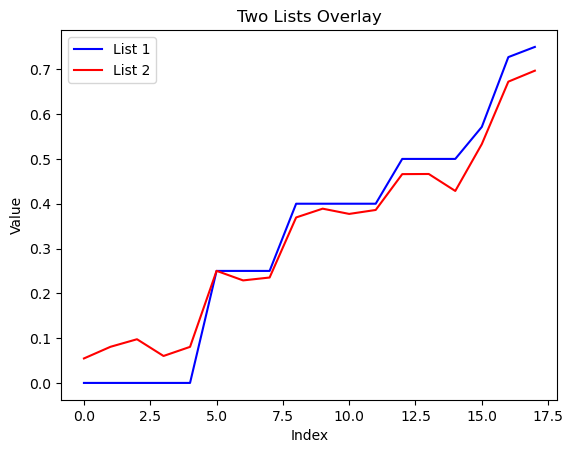

In [32]:
# Plotting
plt.plot(column_1, label='List 1', color='blue')
plt.plot(column_2, label='List 2', color='red')

# Customization
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Two Lists Overlay')
plt.legend()

# Display the plot
plt.show()